# Figure S4

In [441]:
import scanpy as sc
import rapids_singlecell as rsc
import cupy as cp
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_hex
from pandas.api.types import CategoricalDtype
from scipy.cluster.hierarchy import fcluster
import json
import pandas as pd
import seaborn as sns

In [2]:
# Keep text editable
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

In [3]:
from cuml.manifold import TSNE

In [4]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Fig S4a Test Set Xenium Cell Types

In [5]:
data_path = '../Data/xenium_ovarian_cancer_full.h5ad'
out_dir = 'Fig_S1/'

In [6]:
data = sc.read_h5ad(data_path)

In [7]:
data

AnnData object with n_obs × n_vars = 406875 × 5101
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'cell_type', 'is_tumor_cell_type', '10X_cell_type', 'transcriptome_passed_QC', 'is_ovary_cell_type', 'is_in_vitmae_test_set', 'SCimilarity_transcriptome_cell_type', 'SCimilarity_transcriptome_min_dist', 'SCimilarity_image_cell_type', 'SCimilarity_image_min_dist'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_passed_QC'
    uns: 'spatialdata_attrs'
    obsm: 'X_SCimilarity_image_embeds', 'X_SCimilarity_transcriptome_embeds', 'X_vitmae_finetuned_img_features', 'X_vitmae_finetuned_img_features_minmax', 'X_vitmae_imagenet_img_features', 'spatial'

In [8]:
plot_data = ad.AnnData(
    X=data.obsm['X_vitmae_finetuned_img_features'],
    obs=data.obs,
)

In [9]:
plot_data = plot_data[plot_data.obs['is_in_vitmae_test_set'] == True]

In [10]:
sc.pp.scale(plot_data)

/fs/home/schmacke/miniforge3/envs/rapids/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [11]:
rsc.get.anndata_to_GPU(plot_data)

In [12]:
rsc.pp.pca(plot_data, n_comps=100)

[2025-08-31 12:14:48.454] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization


In [13]:
rsc.tl.tsne(
    plot_data,
    n_pcs=100,
    perplexity=30,
    early_exaggeration=12,
    learning_rate=200,
)

[2025-08-31 12:14:49.067] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [452]:
color_list = ['#2F559A', '#5AADC5', '#F5DB12', '#E46425', '#B3262A']
custom_cmap = LinearSegmentedColormap.from_list('custom_gradient', color_list)
n_colors = 17
palette = [custom_cmap(i / (n_colors - 1)) for i in range(n_colors)]
fig, ax = plt.subplots(figsize=(n_colors, 1))
for i, color in enumerate(palette):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
ax.set_xlim(0, n_colors)
ax.set_ylim(0, 1)
ax.axis('off')
# plt.savefig(f'{out_dir}{n_colors}_colored_blocks.pdf', bbox_inches='tight')
plt.close()

In [454]:
order = [
    'Tumor Cells',
    'Tumor Associated Endothelial Cells',
    'Pericytes',
    'SOX2-OT+ Tumor Cells',
    'Fallopian Tube Epithelium',
    'Smooth Muscle Cells',
    'Tumor Associated Fibroblasts',
    'Inflammatory Tumor Cells',
    'Macrophages',
    'Malignant Cells Lining Cyst',
    'T and NK Cells',
    'Ciliated Epithelial Cells',
    'Stromal Associated Fibroblasts',
    'Granulosa Cells',
    'Proliferative Tumor Cells',
    # 'Unassigned',
    'Stromal Associated Endothelial Cells',
    'VEGFA+ Tumor Cells',
]
cluster_to_color_celltype = {cluster_label:palette[i] for i, cluster_label in enumerate(order)}

# white
na_color = (
    np.float64(1.0),
    np.float64(1.0),
    np.float64(1.0),
    np.float64(1.0),
)
cats = list(plot_data.obs['10X_cell_type'].cat.categories)
plot_data.uns['10X_cell_type_colors'] = [cluster_to_color_celltype.get(c, na_color) for c in cats]

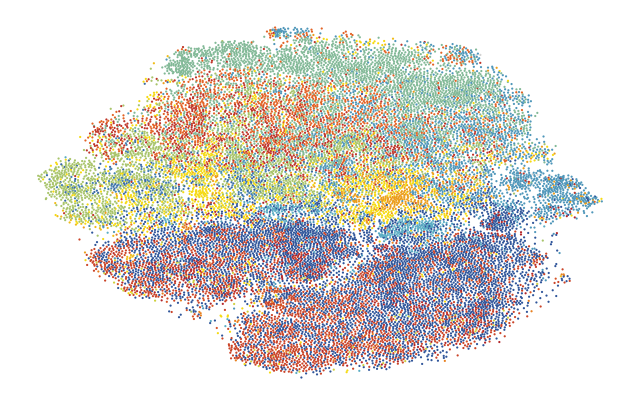

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))

sc.pl.tsne(
    plot_data[plot_data.obs['10X_cell_type'] != 'Unassigned'],
    color = '10X_cell_type',
    ax = ax,
    # s = 0.5,
    s=10,
    alpha = 1,
    frameon=False,
    title='',
    legend_loc=None,
)
fig.savefig(f'{out_dir}Fig_S1a.png', dpi=600, bbox_inches='tight')

In [18]:
pd.DataFrame(
    {
        'cell_id': plot_data.obs['cell_id'],
        'cell_label': plot_data.obs['cell_labels'],
        '10X_cell_type': plot_data.obs['10X_cell_type'],
        'tsne_x': plot_data.obsm['X_tsne'][:,0],
        'tsne_y': plot_data.obsm['X_tsne'][:,1],
    }
).to_csv(f'{out_dir}all_cells_tsne.csv', index=False)

## Fig S4b Transcriptome & Image Information Overlap

### Transcriptome Clusters on Images UMAP

In [108]:
data_path = '../Data/xenium_ovarian_cancer_full.h5ad'
out_dir = 'Fig_S1/'

In [109]:
data = sc.read_h5ad(data_path)

In [110]:
data

AnnData object with n_obs × n_vars = 406875 × 5101
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'cell_type', 'is_tumor_cell_type', '10X_cell_type', 'transcriptome_passed_QC', 'is_ovary_cell_type', 'is_in_vitmae_test_set', 'SCimilarity_transcriptome_cell_type', 'SCimilarity_transcriptome_min_dist', 'SCimilarity_image_cell_type', 'SCimilarity_image_min_dist'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_passed_QC'
    uns: 'spatialdata_attrs'
    obsm: 'X_SCimilarity_image_embeds', 'X_SCimilarity_transcriptome_embeds', 'X_vitmae_finetuned_img_features', 'X_vitmae_finetuned_img_features_minmax', 'X_vitmae_imagenet_img_features', 'spatial'

In [111]:
test_data = data[data.obs['is_in_vitmae_test_set'] == True].copy()

In [112]:
sc.pp.log1p(test_data)

In [113]:
sc.pp.highly_variable_genes(test_data)

In [114]:
sc.pp.scale(test_data)

In [118]:
rsc.get.anndata_to_GPU(test_data)

In [119]:
rsc.pp.neighbors(test_data)

In [123]:
rsc.tl.leiden(test_data, resolution=0.3, key_added='leiden_transcriptome')

In [124]:
rsc.tl.umap(test_data)

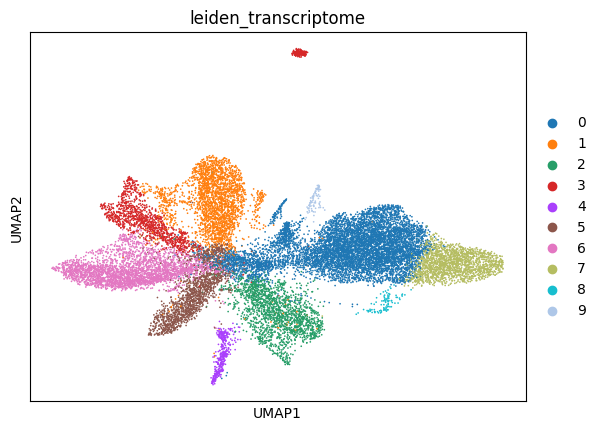

In [125]:
sc.pl.umap(
    test_data,
    color='leiden_transcriptome',
)

In [126]:
plot_data = ad.AnnData(
    X=test_data.obsm['X_vitmae_finetuned_img_features'],
    obs=test_data.obs,
)

In [127]:
sc.pp.scale(plot_data)

In [128]:
rsc.pp.neighbors(plot_data)

[2025-09-06 10:54:49.659] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization


In [129]:
rsc.tl.umap(plot_data)

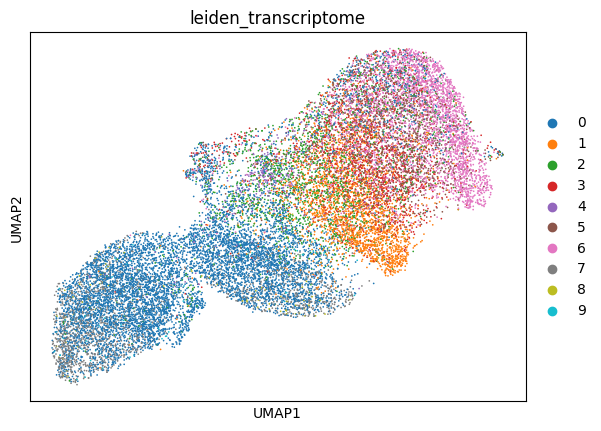

In [130]:
sc.pl.umap(
    plot_data,
    color='leiden_transcriptome',
          )

### Transcriptome Clusters on Images TSNE

In [340]:
data_path = '../Data/xenium_ovarian_cancer_full.h5ad'
out_dir = 'Fig_S1/'

In [341]:
data = sc.read_h5ad(data_path)

In [342]:
data

AnnData object with n_obs × n_vars = 406875 × 5101
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'cell_type', 'is_tumor_cell_type', '10X_cell_type', 'transcriptome_passed_QC', 'is_ovary_cell_type', 'is_in_vitmae_test_set', 'SCimilarity_transcriptome_cell_type', 'SCimilarity_transcriptome_min_dist', 'SCimilarity_image_cell_type', 'SCimilarity_image_min_dist'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_passed_QC'
    uns: 'spatialdata_attrs'
    obsm: 'X_SCimilarity_image_embeds', 'X_SCimilarity_transcriptome_embeds', 'X_vitmae_finetuned_img_features', 'X_vitmae_finetuned_img_features_minmax', 'X_vitmae_imagenet_img_features', 'spatial'

In [343]:
test_data = data[data.obs['is_in_vitmae_test_set'] == True].copy()

In [344]:
sc.pp.log1p(test_data)

In [345]:
sc.pp.highly_variable_genes(test_data)

In [346]:
sc.pp.scale(test_data)

In [347]:
rsc.get.anndata_to_GPU(test_data)

In [348]:
rsc.pp.pca(test_data, n_comps=100)

[2025-09-06 13:23:40.920] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization


In [349]:
rsc.pp.neighbors(test_data)

In [350]:
rsc.tl.leiden(test_data, resolution=0.3, key_added='leiden_transcriptome')

In [397]:
rsc.tl.tsne(
    test_data,
    n_pcs=20,
    perplexity=20,
    early_exaggeration=20,
    learning_rate=200,
)

In [398]:
color_list = ['#2F559A', '#5AADC5', '#F5DB12', '#E46425', '#B3262A']
custom_cmap = LinearSegmentedColormap.from_list('custom_gradient', color_list)
n_colors = len(test_data.obs['leiden_transcriptome'].unique())
palette = [custom_cmap(i / (n_colors - 1)) for i in range(n_colors)]
palette = [to_hex(x) for x in palette]
fig, ax = plt.subplots(figsize=(n_colors, 1))
for i, color in enumerate(palette):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
ax.set_xlim(0, n_colors)
ax.set_ylim(0, 1)
ax.axis('off')
plt.savefig(f'{out_dir}{n_colors}_colored_blocks.pdf', bbox_inches='tight')
plt.close()

In [399]:
cats = list(test_data.obs['leiden_transcriptome'].cat.categories)
cluster_to_color = {cluster_label:palette[i] for i, cluster_label in enumerate(cats)}
# white
na_color = '#FFFFFF'
test_data.uns['leiden_transcriptome_colors'] = [cluster_to_color.get(c, na_color) for c in cats]

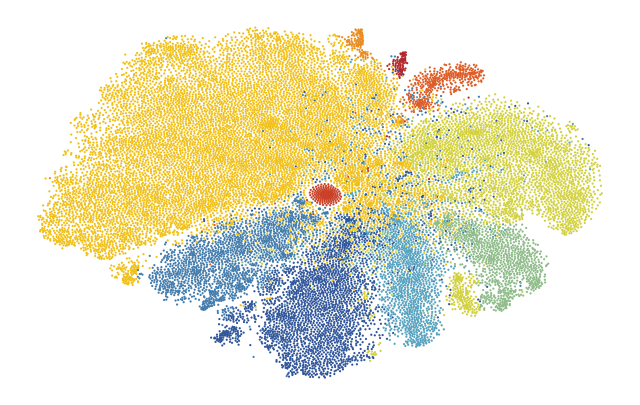

In [401]:
fig, ax = plt.subplots(figsize=(8, 5))
sc.pl.tsne(
    test_data,
    color='leiden_transcriptome',
    ax = ax,
    # s = 0.5,
    s=10,
    alpha = 1,
    frameon=False,
    title='',
    legend_loc=None,
)
fig.savefig(f'{out_dir}Fig_S1b_transcriptome_space.png', dpi=600, bbox_inches='tight',)

In [308]:
tsne_data = pd.read_csv('Fig_S1/_all_cells_tsne.csv').merge(
    test_data.obs[['cell_id', 'leiden_transcriptome']],
    on='cell_id',
    how='left',
)

In [337]:
tsne_adata = ad.AnnData(
    obs=tsne_data,
)
tsne_adata.obsm['X_tsne'] = tsne_data[['tsne_x', 'tsne_y']].to_numpy()
tsne_adata.uns['leiden_transcriptome_colors'] = test_data.uns['leiden_transcriptome_colors']

/fs/home/schmacke/miniforge3/envs/rapids/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


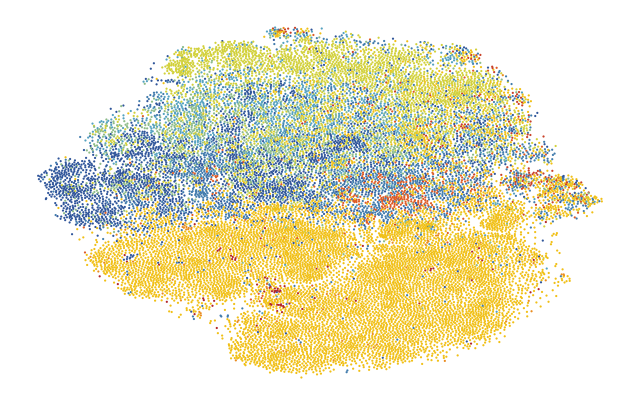

In [339]:
fig, ax = plt.subplots(figsize=(8, 5))

sc.pl.tsne(
    tsne_adata,
    color = 'leiden_transcriptome',
    ax = ax,
    # s = 0.5,
    s=10,
    alpha = 1,
    frameon=False,
    title='',
    legend_loc=None,
)
fig.savefig(f'{out_dir}Fig_S1b_image_space.png', dpi=600, bbox_inches='tight',)

### Image Clusters on Transcriptome

In [151]:
data_path = '../Data/xenium_ovarian_cancer_full.h5ad'
out_dir = 'Fig_S1/'

In [152]:
data = sc.read_h5ad(data_path)

In [153]:
data

AnnData object with n_obs × n_vars = 406875 × 5101
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'cell_type', 'is_tumor_cell_type', '10X_cell_type', 'transcriptome_passed_QC', 'is_ovary_cell_type', 'is_in_vitmae_test_set', 'SCimilarity_transcriptome_cell_type', 'SCimilarity_transcriptome_min_dist', 'SCimilarity_image_cell_type', 'SCimilarity_image_min_dist'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_passed_QC'
    uns: 'spatialdata_attrs'
    obsm: 'X_SCimilarity_image_embeds', 'X_SCimilarity_transcriptome_embeds', 'X_vitmae_finetuned_img_features', 'X_vitmae_finetuned_img_features_minmax', 'X_vitmae_imagenet_img_features', 'spatial'

In [154]:
test_data = data[data.obs['is_in_vitmae_test_set'] == True].copy()

In [155]:
img_data = ad.AnnData(
    X=test_data.obsm['X_vitmae_finetuned_img_features'],
    obs=test_data.obs,
)

In [156]:
sc.pp.scale(img_data)

In [157]:
rsc.get.anndata_to_GPU(img_data)

In [158]:
rsc.pp.neighbors(img_data)

[2025-09-06 11:06:56.216] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization


In [159]:
rsc.tl.leiden(img_data, resolution=0.3, key_added='leiden_img')

In [160]:
rsc.tl.umap(img_data)

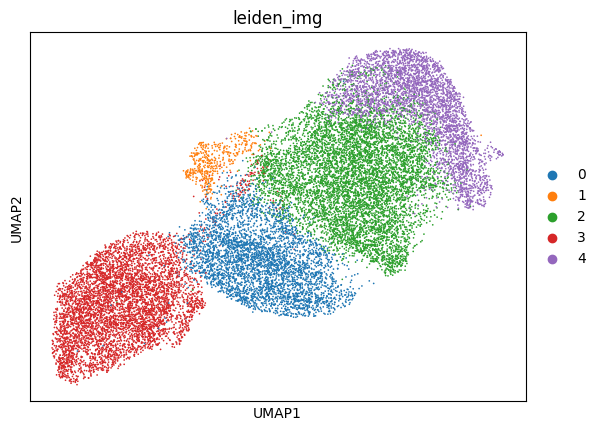

In [161]:
sc.pl.umap(
    img_data,
    color='leiden_img',
)

## Fig S4c knn neighborhood overlap to quantify difference between transcriptome- and image-based embeddings

In [ ]:
import numpy as np
from typing import Iterable, Union, Dict, Any

def _pairwise_dists(X: np.ndarray, metric: str) -> np.ndarray:
    """Return full n×n distance matrix. diag set to +inf."""
    X = np.asarray(X, dtype=float)
    n = X.shape[0]
    if metric == "euclidean":
        xsq = np.sum(X**2, axis=1, keepdims=True)
        D = xsq + xsq.T - 2 * (X @ X.T)
        np.maximum(D, 0, out=D)  # numerical safety
        np.fill_diagonal(D, np.inf)
        return np.sqrt(D, out=D)
    elif metric == "cosine":
        norms = np.linalg.norm(X, axis=1, keepdims=True)
        norms[norms == 0] = 1.0
        Xn = X / norms
        S = Xn @ Xn.T
        np.fill_diagonal(S, -np.inf)  # so 1 - S -> +inf on diag
        D = 1.0 - S
        return D
    else:
        raise ValueError("metric must be 'euclidean' or 'cosine'")

def _knn_indices_from_D(D: np.ndarray, k: int) -> np.ndarray:
    """Top-k neighbor indices per row from a distance matrix."""
    n = D.shape[0]
    k = int(min(k, n - 1))
    # argpartition gives k smallest in arbitrary order; sort those by distance for tie stability
    idx_part = np.argpartition(D, kth=k, axis=1)[:, :k]
    # stable order within the top-k
    row_indices = np.arange(n)[:, None]
    part_d = D[row_indices, idx_part]
    order = np.argsort(part_d, axis=1, kind="mergesort")
    return idx_part[row_indices, order]

def _mutual_mask(knn: np.ndarray, n: int) -> np.ndarray:
    """Boolean mutual-kNN adjacency (n×n). mutual[i,j]=True iff j in N(i) and i in N(j)."""
    A = np.zeros((n, n), dtype=bool)
    rows = np.repeat(np.arange(n), knn.shape[1])
    A[rows, knn.ravel()] = True
    return A & A.T

def _overlap_at_k(knn1: np.ndarray, knn2: np.ndarray, k: int, mutual1=None, mutual2=None):
    """Per-point overlap fraction |N1∩N2|/k. Optionally enforce mutual-kNN within each view."""
    n = knn1.shape[0]
    o = np.empty(n, dtype=float)
    if mutual1 is not None:
        # filter N1 by mutuality
        knn1 = [knn1[i][mutual1[i, knn1[i]]] for i in range(n)]
    else:
        knn1 = [knn1[i] for i in range(n)]
    if mutual2 is not None:
        knn2 = [knn2[i][mutual2[i, knn2[i]]] for i in range(n)]
    else:
        knn2 = [knn2[i] for i in range(n)]
    for i in range(n):
        s1 = knn1[i]
        s2 = knn2[i]
        if s1.size == 0 or s2.size == 0:
            o[i] = 0.0
        else:
            # use set intersection on numpy arrays
            inter = np.intersect1d(s1, s2, assume_unique=False).size
            o[i] = inter / float(k)
    return o

def neighborhood_overlap(
    a: np.ndarray,
    b: np.ndarray,
    k: Union[int, Iterable[int]] = 100,
    metric: str = "euclidean",
    mutual: bool = False,
    n_bootstrap: int = 0,
    n_perm: int = 0,
    random_state: Union[int, None] = None,
) -> Dict[str, Any]:
    """
    Compute normalized neighborhood overlap NO@k between embeddings a and b.
    Returns dict with per-k results and extras.
    """
    rng = np.random.default_rng(random_state)
    a = np.asarray(a); b = np.asarray(b)
    n = a.shape[0]
    if b.shape[0] != n:
        raise ValueError("a and b must have the same number of rows (samples).")

    ks = [int(k)] if isinstance(k, (int, np.integer)) else sorted({int(x) for x in k if 1 <= x < n})
    if not ks:
        raise ValueError("k must contain at least one integer in [1, n-1].")

    # Precompute distances and kNN
    Da = _pairwise_dists(a, metric)
    Db = _pairwise_dists(b, metric)
    knn_a = {kk: _knn_indices_from_D(Da, kk) for kk in ks}
    knn_b = {kk: _knn_indices_from_D(Db, kk) for kk in ks}
    mutual_a = _mutual_mask(knn_a[max(ks)], n) if mutual else None  # build on largest k, still valid for <=k
    mutual_b = _mutual_mask(knn_b[max(ks)], n) if mutual else None

    results = {}
    for kk in ks:
        o = _overlap_at_k(knn_a[kk], knn_b[kk], kk, mutual_a, mutual_b)  # per-point raw overlap fraction
        raw_mean = float(np.mean(o))
        chance = kk / (n - 1)
        no = (raw_mean - chance) / (1 - chance) if chance < 1 else 0.0
        U = 1.0 - no
        out = {
            "k": kk,
            "n": n,
            "raw_mean_overlap": raw_mean,     # E[|N1∩N2|]/k
            "chance_level": chance,
            "normalized_overlap": no,         # in [0,1] if baseline-adjusted
            "uniqueness_proxy": U,            # 1 - NO
            "per_point_overlap": o,           # array length n
        }

        # Bootstrap CI on normalized overlap
        if n_bootstrap and n_bootstrap > 0:
            boots = np.empty(n_bootstrap, dtype=float)
            for bi in range(n_bootstrap):
                idx = rng.integers(0, n, size=n)
                rb = float(np.mean(o[idx]))
                boots[bi] = (rb - chance) / (1 - chance)
            ci = np.quantile(boots, [0.025, 0.975]).tolist()
            out["bootstrap_NO_CI95"] = ci

        # Permutation test: shuffle correspondence between views
        if n_perm and n_perm > 0:
            perm_no = np.empty(n_perm, dtype=float)
            for pi in range(n_perm):
                perm = rng.permutation(n)
                # recompute overlap vs permuted rows in b by permuting distance matrix rows/cols
                Dbp = Db[perm][:, perm]
                knn_bp = _knn_indices_from_D(Dbp, kk)
                op = _overlap_at_k(knn_a[kk], knn_bp, kk, mutual_a, mutual_b)
                perm_no[pi] = (float(np.mean(op)) - chance) / (1 - chance)
            pval = float((np.sum(perm_no >= no) + 1) / (n_perm + 1))  # right-tail
            out["perm_pvalue_NO"] = pval
        results[kk] = out

    # If multiple k, add simple summaries
    if len(ks) > 1:
        mean_NO = float(np.mean([results[kk]["normalized_overlap"] for kk in ks]))
        auc_like = float(np.trapz([results[kk]["normalized_overlap"] for kk in ks], x=ks) / (ks[-1] - ks[0]))
        results["summary"] = {"mean_NO_over_ks": mean_NO, "AUC_NO_vs_k": auc_like}

    return results

In [407]:
data_path = '../Data/xenium_ovarian_cancer_full.h5ad'
out_dir = 'Fig_S1/'

In [408]:
data = sc.read_h5ad(data_path)

In [409]:
data

AnnData object with n_obs × n_vars = 406875 × 5101
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'cell_type', 'is_tumor_cell_type', '10X_cell_type', 'transcriptome_passed_QC', 'is_ovary_cell_type', 'is_in_vitmae_test_set', 'SCimilarity_transcriptome_cell_type', 'SCimilarity_transcriptome_min_dist', 'SCimilarity_image_cell_type', 'SCimilarity_image_min_dist'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_passed_QC'
    uns: 'spatialdata_attrs'
    obsm: 'X_SCimilarity_image_embeds', 'X_SCimilarity_transcriptome_embeds', 'X_vitmae_finetuned_img_features', 'X_vitmae_finetuned_img_features_minmax', 'X_vitmae_imagenet_img_features', 'spatial'

In [410]:
test_data = data[data.obs['is_in_vitmae_test_set'] == True].copy()

In [415]:
embed_a = test_data[test_data.obs['10X_cell_type'] == 'Macrophages'].obsm['X_vitmae_finetuned_img_features']
embed_b = test_data[test_data.obs['10X_cell_type'] == 'Macrophages'].X.toarray()

In [419]:
embed_a = test_data.obsm['X_vitmae_finetuned_img_features']
embed_b = test_data.X.toarray()

In [421]:
overlap = neighborhood_overlap(embed_a, embed_b)

In [423]:
overlap

{100: {'k': 100,
  'n': 20344,
  'raw_mean_overlap': 0.015179905623279593,
  'chance_level': 0.00491569581674286,
  'normalized_overlap': 0.010314914790020094,
  'uniqueness_proxy': 0.9896850852099799,
  'per_point_overlap': array([0.  , 0.  , 0.  , ..., 0.01, 0.04, 0.  ])}}

In [424]:
test_data.obs['100_neigbours_overlap'] = overlap[100]['per_point_overlap']

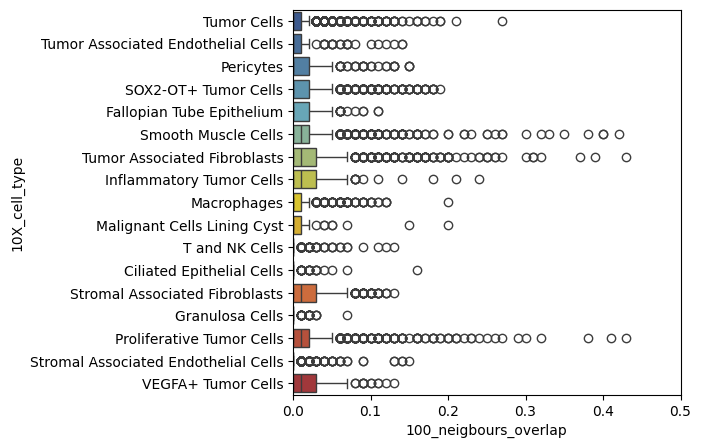

In [481]:
plt.figure(figsize=(5, 5))
plot_data = test_data.obs[test_data.obs['10X_cell_type'] != 'Unassigned'].copy()
plot_data["10X_cell_type"] = plot_data["10X_cell_type"].cat.remove_unused_categories()
plot_data["10X_cell_type"] = plot_data["10X_cell_type"].cat.reorder_categories(list(cluster_to_color_celltype.keys()), ordered=True)
sns.boxplot(
    data=plot_data,
    y="10X_cell_type",
    x="100_neigbours_overlap",
    hue="10X_cell_type",
    legend=False,
    palette=cluster_to_color_celltype,
    # orient='h',
)
plt.xlim([0,0.5])
# plt.show()
plt.savefig(f'{out_dir}Fig_S1c.pdf', dpi=600, bbox_inches='tight')

## Fig S4d Macrophages

In [19]:
plot_macs = plot_data[plot_data.obs['10X_cell_type'] == 'Macrophages'].copy()

In [20]:
rsc.pp.scale(plot_macs)

In [21]:
rsc.pp.neighbors(plot_macs, n_neighbors=5, use_rep='X')

In [22]:
rsc.tl.leiden(plot_macs, resolution=0.4, key_added='vitmae_leiden_macs')

In [23]:
# Convert Leiden clusters to 1-based index
plot_macs.obs['vitmae_leiden_macs'] = plot_macs.obs['vitmae_leiden_macs'].astype(int).add(1).astype(str).astype('category')
groups_to_plot = ['2', '3', '4', '5', '8', '6', '1', '7']

In [24]:
merged_obs = plot_data.obs.merge(
    plot_macs.obs[['cell_id', 'vitmae_leiden_macs']],
    right_on='cell_id',
    left_on='cell_id',
    how='left'
)
plot_data.obs = merged_obs

In [52]:
color_list = ['#2F559A', '#5AADC5', '#F5DB12', '#E46425', '#B3262A']
custom_cmap = LinearSegmentedColormap.from_list('custom_gradient', color_list)
n_colors = len(groups_to_plot)
palette = [custom_cmap(i / (n_colors - 1)) for i in range(n_colors)]
fig, ax = plt.subplots(figsize=(n_colors, 1))
for i, color in enumerate(palette):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
ax.set_xlim(0, n_colors)
ax.set_ylim(0, 1)
ax.axis('off')
plt.savefig(f'{out_dir}{n_colors}_colored_blocks.pdf', bbox_inches='tight')
plt.close()

In [26]:
# cluster_to_color = {cluster_label:palette[i] for i, cluster_label in enumerate(plot_macs.obs['vitmae_leiden_macs'].unique())}
cluster_to_color = {cluster_label:palette[i] for i, cluster_label in enumerate(groups_to_plot)}
# white
na_color = (
    np.float64(1.0),
    np.float64(1.0),
    np.float64(1.0),
    np.float64(1.0),
)
cats = list(plot_data.obs['vitmae_leiden_macs'].cat.categories)
plot_data.uns['vitmae_leiden_macs_colors'] = [cluster_to_color.get(c, na_color) for c in cats]

In [27]:
with open(f"{out_dir}cluster_to_color.json", "w") as f:
    json.dump(cluster_to_color, f)

/fs/home/schmacke/miniforge3/envs/rapids/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1148: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=palette[label], label=label)


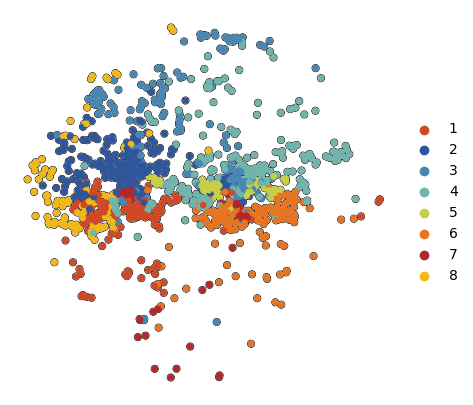

In [53]:
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.tsne(
    plot_data[plot_data.obs['10X_cell_type'] == 'Macrophages'],
    color = 'vitmae_leiden_macs',
    ax = ax,
    # s = 10,
    alpha = 1,
    add_outline = True,
    outline_width = (0.1,0),
    frameon=False,
    title='',
    na_color='white',
    groups=groups_to_plot,
    # legend_loc=None,
)
fig.savefig(f'{out_dir}Fig_S1d.png', dpi=600, bbox_inches='tight',)

In [35]:
rsc.pp.neighbors(plot_data, n_neighbors=15)
rsc.tl.umap(plot_data)

/fs/home/schmacke/miniforge3/envs/rapids/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1148: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=palette[label], label=label)


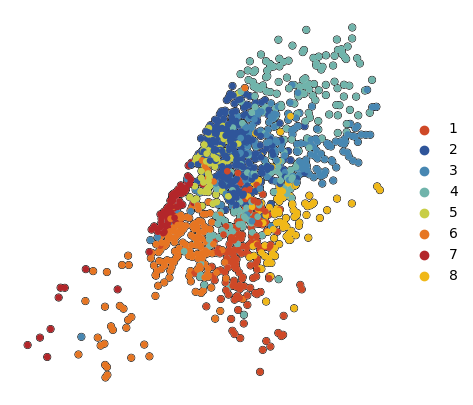

In [36]:
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.umap(
    plot_data[plot_data.obs['10X_cell_type'] == 'Macrophages'],
    color = 'vitmae_leiden_macs',
    ax = ax,
    # s = 10,
    alpha = 1,
    add_outline = True,
    outline_width = (0.1,0),
    frameon=False,
    title='',
    na_color='white',
    groups=groups_to_plot,
)

/fs/home/schmacke/miniforge3/envs/rapids/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1148: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=palette[label], label=label)


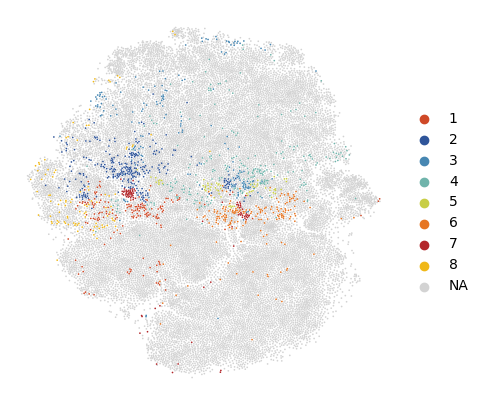

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.tsne(
    plot_data,
    color = 'vitmae_leiden_macs',
    ax = ax,
    # s = 2,
    alpha = 1,
    frameon=False,
    title='',
    na_color='lightgrey',
    groups=groups_to_plot,
)

## Fig S4e Map Macrophages onto Tissue

In [38]:
macs_clusters = plot_data.obs[(plot_data.obs['10X_cell_type'] == 'Macrophages') & (plot_data.obs['is_in_vitmae_test_set'] == True)][['cell_id','vitmae_leiden_macs']].copy()

In [40]:
macs_clusters.to_csv(f'{out_dir}macs_clusters.csv', index=False)

## Fig S4f Differentially Expressed Genes between Macrophage Leiden Clusters

In [41]:
data_genes = data.copy()
data_genes = data_genes[data_genes.obs['is_in_vitmae_test_set']]

In [42]:
merged_obs = data_genes.obs.merge(
    plot_macs.obs[['cell_id', 'vitmae_leiden_macs']],
    right_on='cell_id',
    left_on='cell_id',
    how='left'
)
data_genes.obs = merged_obs

In [43]:
data_genes_macs = data_genes[data_genes.obs['cell_type'] == 'Macrophages'].copy()

/fs/home/schmacke/miniforge3/envs/rapids/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [44]:
sc.pp.normalize_total(data_genes_macs, target_sum=10e4)

log1p is necessary here, because DE gene analysis is sensitive to high-variance outlier genes. In contrast to embedding into SCimilarity, the absolute range of values does not matter here.

In [45]:
sc.pp.log1p(data_genes_macs)

In [46]:
sc.pp.pca(data_genes_macs)

In [47]:
sc.tl.rank_genes_groups(
    data_genes_macs,
    groupby="vitmae_leiden_macs",
    method="wilcoxon"
)

In [48]:
sc.tl.dendrogram(
    data_genes_macs,
    groupby="vitmae_leiden_macs",
)

In [49]:
data_genes_macs.uns['rank_genes_groups']['pvals_adj']

rec.array([(1.85072515e-14, 0.06838251, 2.66040498e-15, 3.07491513e-03, 1., 1.35503601e-10, 3.82447561e-05, 1.15467925e-10),
           (3.25117484e-14, 0.18714723, 1.13305024e-10, 1.00000000e+00, 1., 6.69169260e-10, 4.02243902e-04, 2.83212609e-10),
           (8.21324595e-09, 1.        , 6.18200009e-06, 1.00000000e+00, 1., 4.26492135e-03, 3.68822234e-03, 8.74509098e-08),
           ...,
           (1.29951219e-01, 0.18714723, 6.62705661e-04, 4.04108158e-02, 1., 1.24286605e-02, 3.39755772e-01, 1.00000000e+00),
           (2.09695777e-02, 0.18714723, 1.36279068e-05, 4.36970127e-05, 1., 1.06856497e-03, 2.72750451e-01, 1.00000000e+00),
           (8.43173516e-04, 0.06838251, 4.96616862e-12, 2.30786202e-06, 1., 1.35503601e-10, 1.61595516e-01, 1.00000000e+00)],
          dtype=[('1', '<f8'), ('2', '<f8'), ('3', '<f8'), ('4', '<f8'), ('5', '<f8'), ('6', '<f8'), ('7', '<f8'), ('8', '<f8')])

In [50]:
color_list_blue = ['#FFFFFF','#2F559A']
custom_cmap_blue = LinearSegmentedColormap.from_list('custom_gradient', color_list_blue)

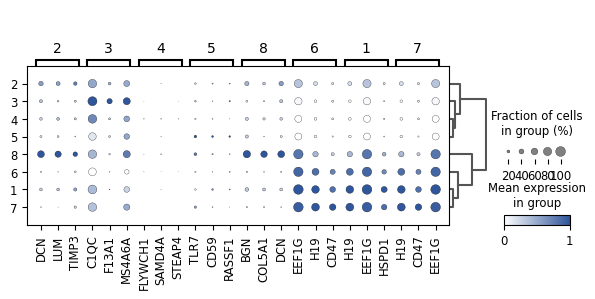

In [56]:
fig, ax = plt.subplots(figsize=(7, 2.8)) #8,3
dp = sc.pl.rank_genes_groups_dotplot(
    data_genes_macs,
    groupby="vitmae_leiden_macs",
    standard_scale="var",
    n_genes=3,
    cmap=custom_cmap_blue,
    ax=ax,
    min_logfoldchange=1.5,
    # groups=groups_to_plot,
    dendrogram=True,
    return_fig=True,
)
dp.style(largest_dot=50) #120
dp.show()
fig.tight_layout()
fig.savefig(f'{out_dir}Fig_S1f.pdf')